Charidi Stevens


# **Task I**

In [149]:
import numpy as np
np.random.seed(0)

In [150]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [151]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms

In [152]:
transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])
                                ])

data_dir = "drive/MyDrive/dataset/train"
test_data_dir = "drive/MyDrive/dataset/test"

train_data = ImageFolder(root = data_dir, transform = transform)

test_data = ImageFolder(root = test_data_dir, transform = transform)



batch_size=32
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

Shape of X [N, C, H, W]: torch.Size([32, 3, 224, 224])
Shape of Y: torch.Size([32])


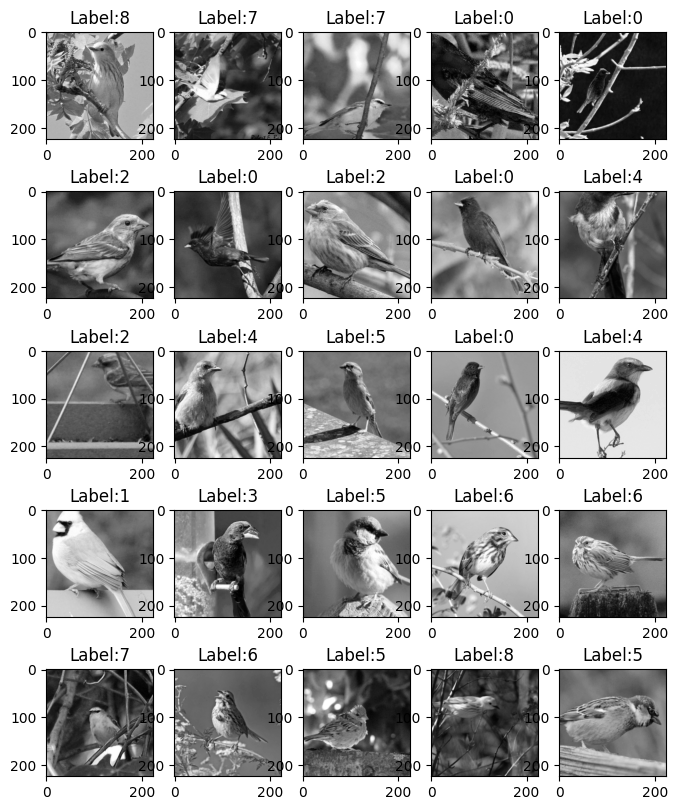

In [153]:
import matplotlib.pyplot as plt

data = next(iter(train_dataloader))


X = data[0]
Y = data[1]

print("Shape of X [N, C, H, W]:", X.shape)
print("Shape of Y:", Y.shape)
plt.figure(figsize=(8,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.imshow(X[i,0,:,:], cmap="gray")
  plt.title("Label:%i" %Y[i])

In [154]:
from torch import nn

class MLP(nn.Module):
  def __init__(self):
    super(MLP, self).__init__()
    self.flatten = nn.Flatten()
    self.input_layer = nn.Sequential(nn.Linear(3*224*224, 4096), nn.ReLU(),)
    self.hidden_layer = nn.Sequential(nn.Linear(4096,512),nn.ReLU())
    self.output_layer = nn.Linear(512, 9)

  def forward(self, x):
    x = self.flatten(x)
    x = self.input_layer(x)
    x = self.hidden_layer(x)
    logits = self.output_layer(x)

    return logits

In [155]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using %s device" %device)

model = MLP().to(device)

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

epochs = 5

Using cuda device


In [156]:
def train(dataloader, model, loss_fn, optimizer, device):
  model.train()

  for step, (X, y) in enumerate(dataloader):
    X = X.to(device)
    y = y.to(device)

    optimizer.zero_grad()

    logits = model(X)

    loss = loss_fn(logits, y)

    loss.backward()
    optimizer.step()

  return model

In [157]:
def reshape_list(in_list):
  output_list = []
  b = len(in_list)
  for i in range(b):
    r, c = np.shape(in_list[i])
    for j in range(r):
      output_list.append(in_list[i][j])

  return output_list
def test(dataloader, model, loss_fn, device):
  test_loss = 0.0
  prob_list = []
  pred_list = np.array([])
  label_list = np.array([])

  with torch.no_grad():
    for X, y in dataloader:
      X = X.to(device)
      y = y.to(device)
      logits = model(X)

      loss = loss_fn(logits, y)

      test_loss += loss.item()


      prob = torch.softmax(logits, 1)
      prob_list.append(prob.cpu().numpy())
      pred_list = np.concatenate((pred_list, torch.argmax(prob, dim=1).cpu().numpy()))
      label_list = np.concatenate((label_list, y.cpu().numpy()))

    test_loss /= len(dataloader)

    return reshape_list(prob_list), pred_list, label_list, test_loss

In [158]:
import tqdm
import numpy as np
from sklearn import metrics


train_hist = []
test_hist = []

for e in tqdm.tqdm(range(epochs)):

  model = train(train_dataloader, model, loss_fn, optimizer, device)

  train_prob_list, train_pred_list, train_label_list, train_loss = test(train_dataloader, model, loss_fn, device)
  train_f1 = metrics.f1_score(train_label_list, train_pred_list, average="weighted")


  test_prob_list, test_pred_list, test_label_list, test_loss = test(test_dataloader, model, loss_fn, device)
  test_f1 = metrics.f1_score(test_label_list, test_pred_list, average="weighted")

  train_hist.append([train_loss, train_f1])
  test_hist.append([test_loss, test_f1])

print(e)

100%|██████████| 5/5 [00:49<00:00,  9.94s/it]

4


In [159]:
classes = ["Yellow Warbler","Blue Winged Warbler", "Song Sparrow","House Sparrow", "Florida Jay", "Blue Grosbeak", "Purple Finch", "Cardinal", "Indigo Bunting"]
print("Train Set")
print(metrics.classification_report(train_label_list, train_pred_list, target_names=[str(item) for item in classes]))
print("\nTest Set")
print(metrics.classification_report(test_label_list, test_pred_list, target_names= [str(item) for item in classes]))

Train Set
                     precision    recall  f1-score   support

     Yellow Warbler       1.00      1.00      1.00        50
Blue Winged Warbler       0.98      0.96      0.97        47
       Song Sparrow       0.94      0.98      0.96        50
      House Sparrow       1.00      1.00      1.00        50
        Florida Jay       0.98      1.00      0.99        50
      Blue Grosbeak       0.91      0.98      0.94        50
       Purple Finch       1.00      0.94      0.97        50
           Cardinal       1.00      0.96      0.98        50
     Indigo Bunting       1.00      0.98      0.99        50

           accuracy                           0.98       447
          macro avg       0.98      0.98      0.98       447
       weighted avg       0.98      0.98      0.98       447


Test Set
                     precision    recall  f1-score   support

     Yellow Warbler       0.60      0.30      0.40        10
Blue Winged Warbler       0.60      0.60      0.60        10


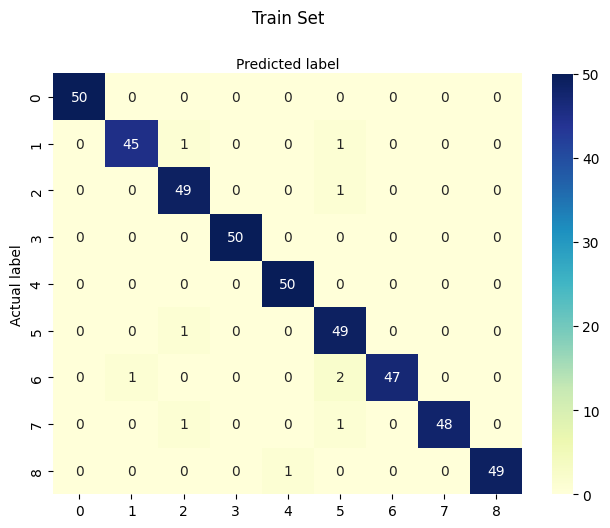

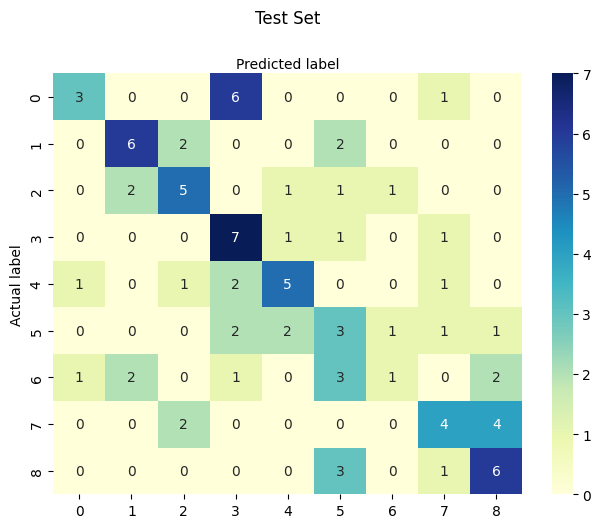

In [160]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def display_confusion_matrix(pred_list, label_list, class_names, title='train set'):
  cnf_matrix_train = metrics.confusion_matrix(pred_list, label_list)

  fig, ax =  plt.subplots()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names)
  plt.yticks(tick_marks, class_names)
  sns.heatmap(pd.DataFrame(cnf_matrix_train), annot=True, cmap="YlGnBu" ,fmt='g')
  ax.xaxis.set_label_position("top")
  plt.tight_layout()
  plt.title(title, y=1.1)
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

display_confusion_matrix(train_label_list, train_pred_list, classes, title='Train Set')
display_confusion_matrix(test_label_list, test_pred_list, classes, title='Test Set')

Text(0.5, 0, 'Epochs')

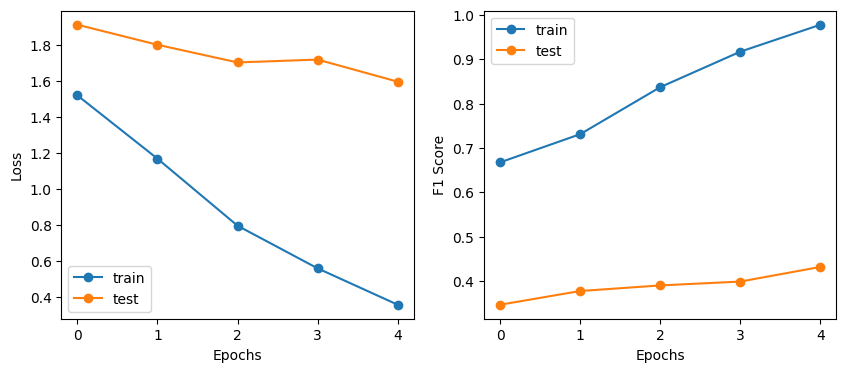

In [161]:
train_hist = np.array(train_hist)
test_hist = np.array(test_hist)

fontsize = 10
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_hist[:,0], "-o")
plt.plot(test_hist[:,0], "-o")
plt.legend(("train", "test"))
plt.ylabel("Loss", fontsize=fontsize)
plt.xlabel("Epochs", fontsize=fontsize)

plt.subplot(1,2,2)
plt.plot(train_hist[:,1], "-o")
plt.plot(test_hist[:,1], "-o")
plt.legend(("train", "test"))
plt.ylabel("F1 Score", fontsize=fontsize)
plt.xlabel("Epochs", fontsize=fontsize)

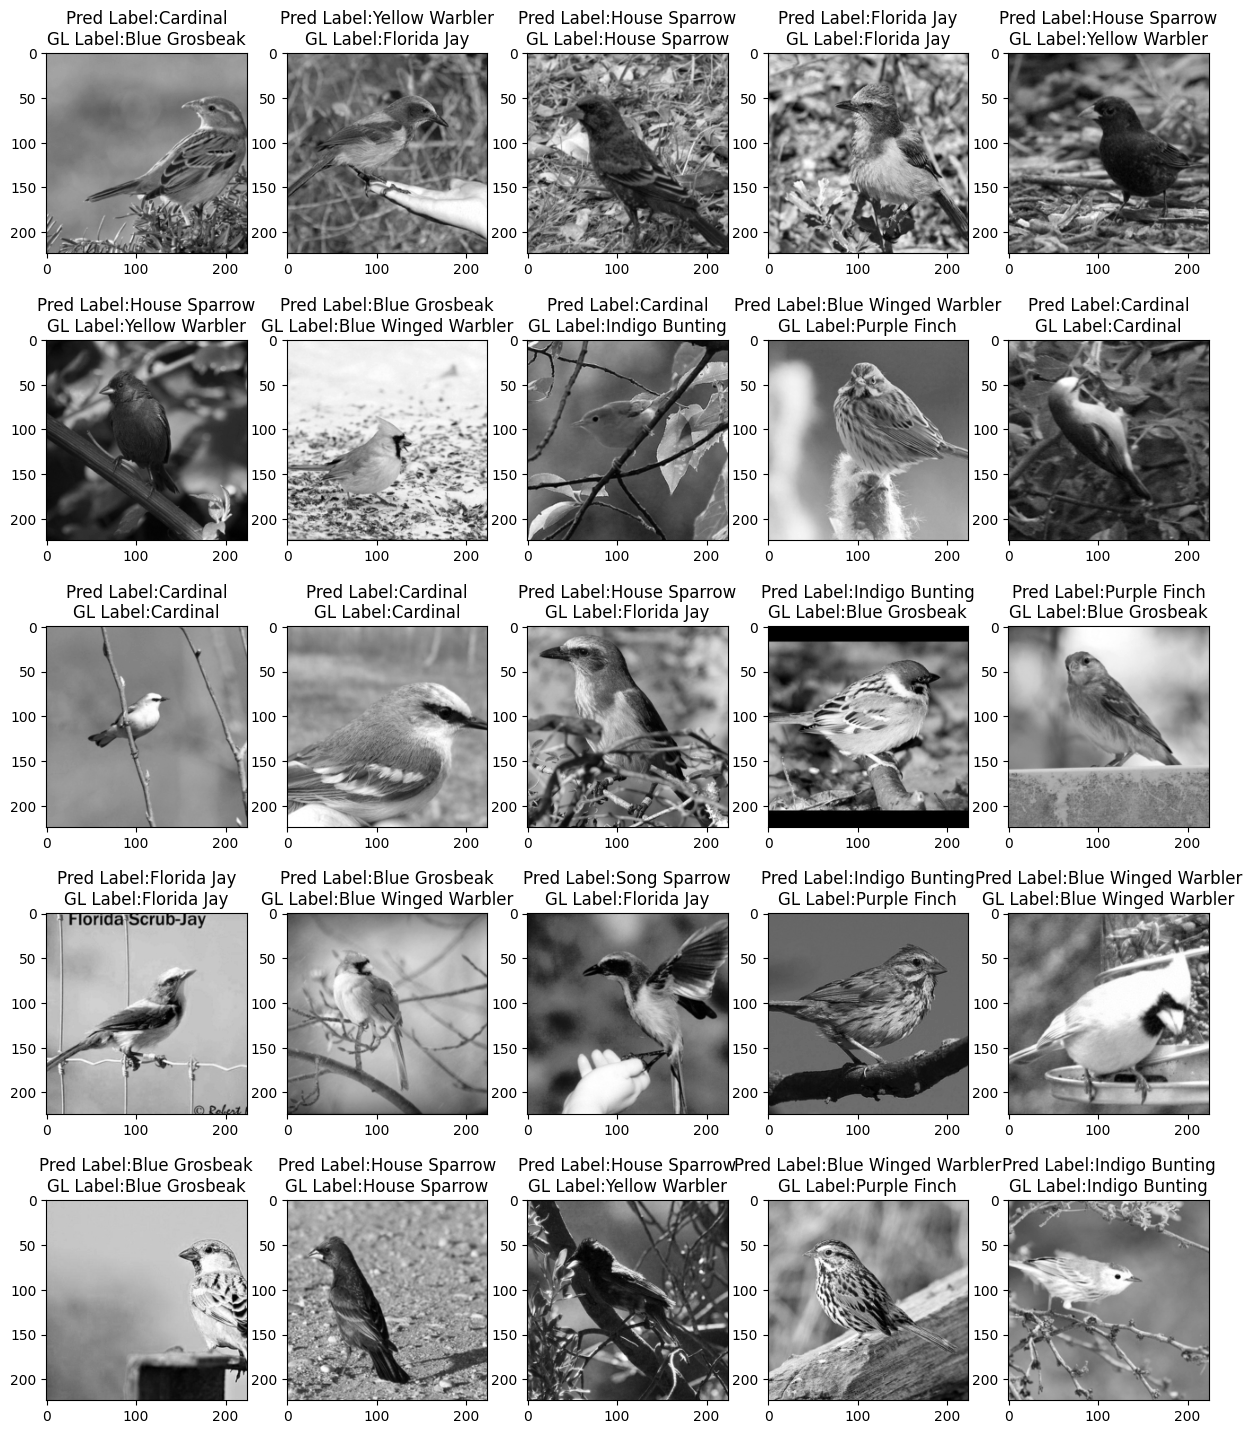

In [162]:

model.eval()
model = model.to("cuda")

for X, y in test_dataloader:
  X = X.to(device)
  y = y.to(device)
  with torch.no_grad():
    pred = model(X)
    pred_labels = pred.argmax(1)
  break

plt.figure(figsize=(15,18))
for i in range(25):
  y_hat = pred_labels[i].item()
  y_gt = y[i].item()
  plt.subplot(5,5,i+1)
  plt.imshow(X[i, 0, :, :].cpu().numpy(), cmap="gray")
  plt.title('Pred Label:%s\nGL Label:%s' %(classes[y_hat], classes[y_gt]))

## **Task II**

In [170]:
from torchvision import transforms
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),

    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = "drive/MyDrive/dataset/train"
test_data_dir = "drive/MyDrive/dataset/test"

train_data = ImageFolder(root = data_dir, transform = transforms_train)

test_data = ImageFolder(root = test_data_dir, transform = transforms_test)



batch_size=32
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [171]:
import torch.optim as optim
from torchvision import models

model = models.resnet18(weights='IMAGENET1K_V1')

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 9)
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()

optimizer = optim.AdamW(model.parameters(), lr=1.4e-4, weight_decay=1e-4)


In [172]:
import tqdm
import numpy as np
from sklearn import metrics


train_hist = []
test_hist = []


for e in tqdm.tqdm(range(epochs)):

  model = train(train_dataloader, model, loss_fn, optimizer, device)

  train_prob_list, train_pred_list, train_label_list, train_loss = test(train_dataloader, model, loss_fn, device)
  train_f1 = metrics.f1_score(train_label_list, train_pred_list, average="weighted")


  test_prob_list, test_pred_list, test_label_list, test_loss = test(test_dataloader, model, loss_fn, device)
  test_f1 = metrics.f1_score(test_label_list, test_pred_list, average="weighted")

  train_hist.append([train_loss, train_f1])
  test_hist.append([test_loss, test_f1])

print(e)

100%|██████████| 5/5 [00:48<00:00,  9.79s/it]

4


In [1]:
print("Train Set")
print(metrics.classification_report(train_label_list, train_pred_list, target_names=[str(item) for item in classes]))
print("\nTest Set")
print(metrics.classification_report(test_label_list, test_pred_list, target_names= [str(item) for item in classes]))

Train Set


NameError: name 'metrics' is not defined

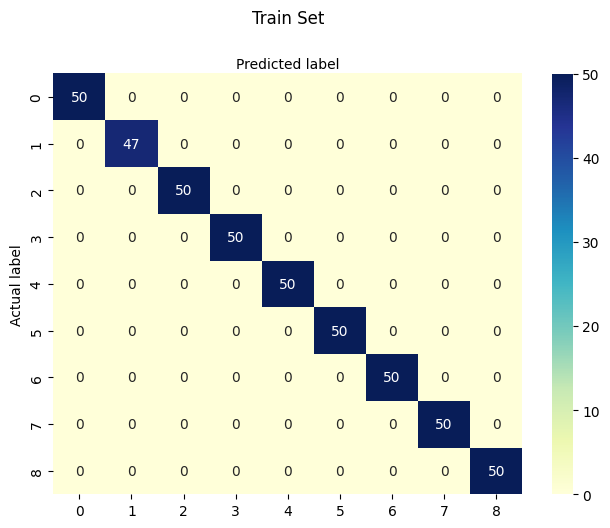

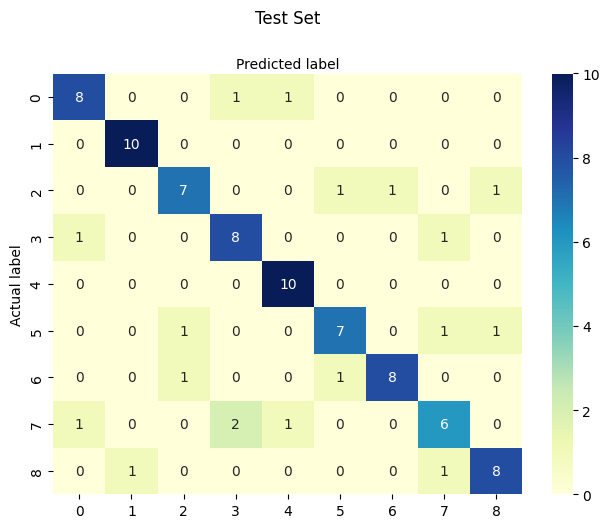

In [174]:
display_confusion_matrix(train_label_list, train_pred_list, classes, title='Train Set')
display_confusion_matrix(test_label_list, test_pred_list, classes, title='Test Set')

Text(0.5, 0, 'Epochs')

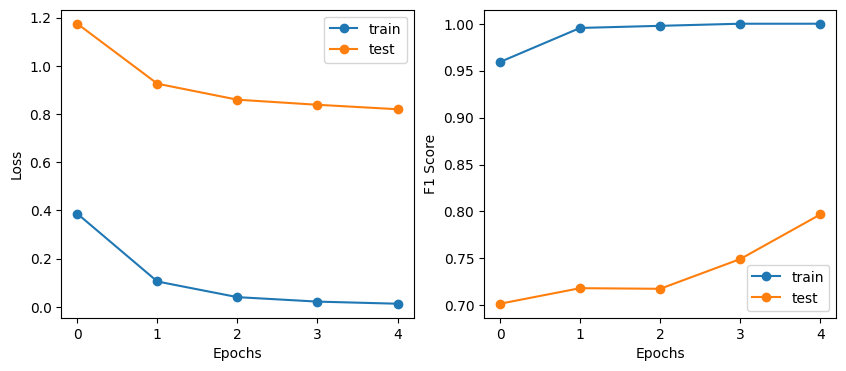

In [175]:
train_hist = np.array(train_hist)
test_hist = np.array(test_hist)

fontsize = 10
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_hist[:,0], "-o")
plt.plot(test_hist[:,0], "-o")
plt.legend(("train", "test"))
plt.ylabel("Loss", fontsize=fontsize)
plt.xlabel("Epochs", fontsize=fontsize)

plt.subplot(1,2,2)
plt.plot(train_hist[:,1], "-o")
plt.plot(test_hist[:,1], "-o")
plt.legend(("train", "test"))
plt.ylabel("F1 Score", fontsize=fontsize)
plt.xlabel("Epochs", fontsize=fontsize)

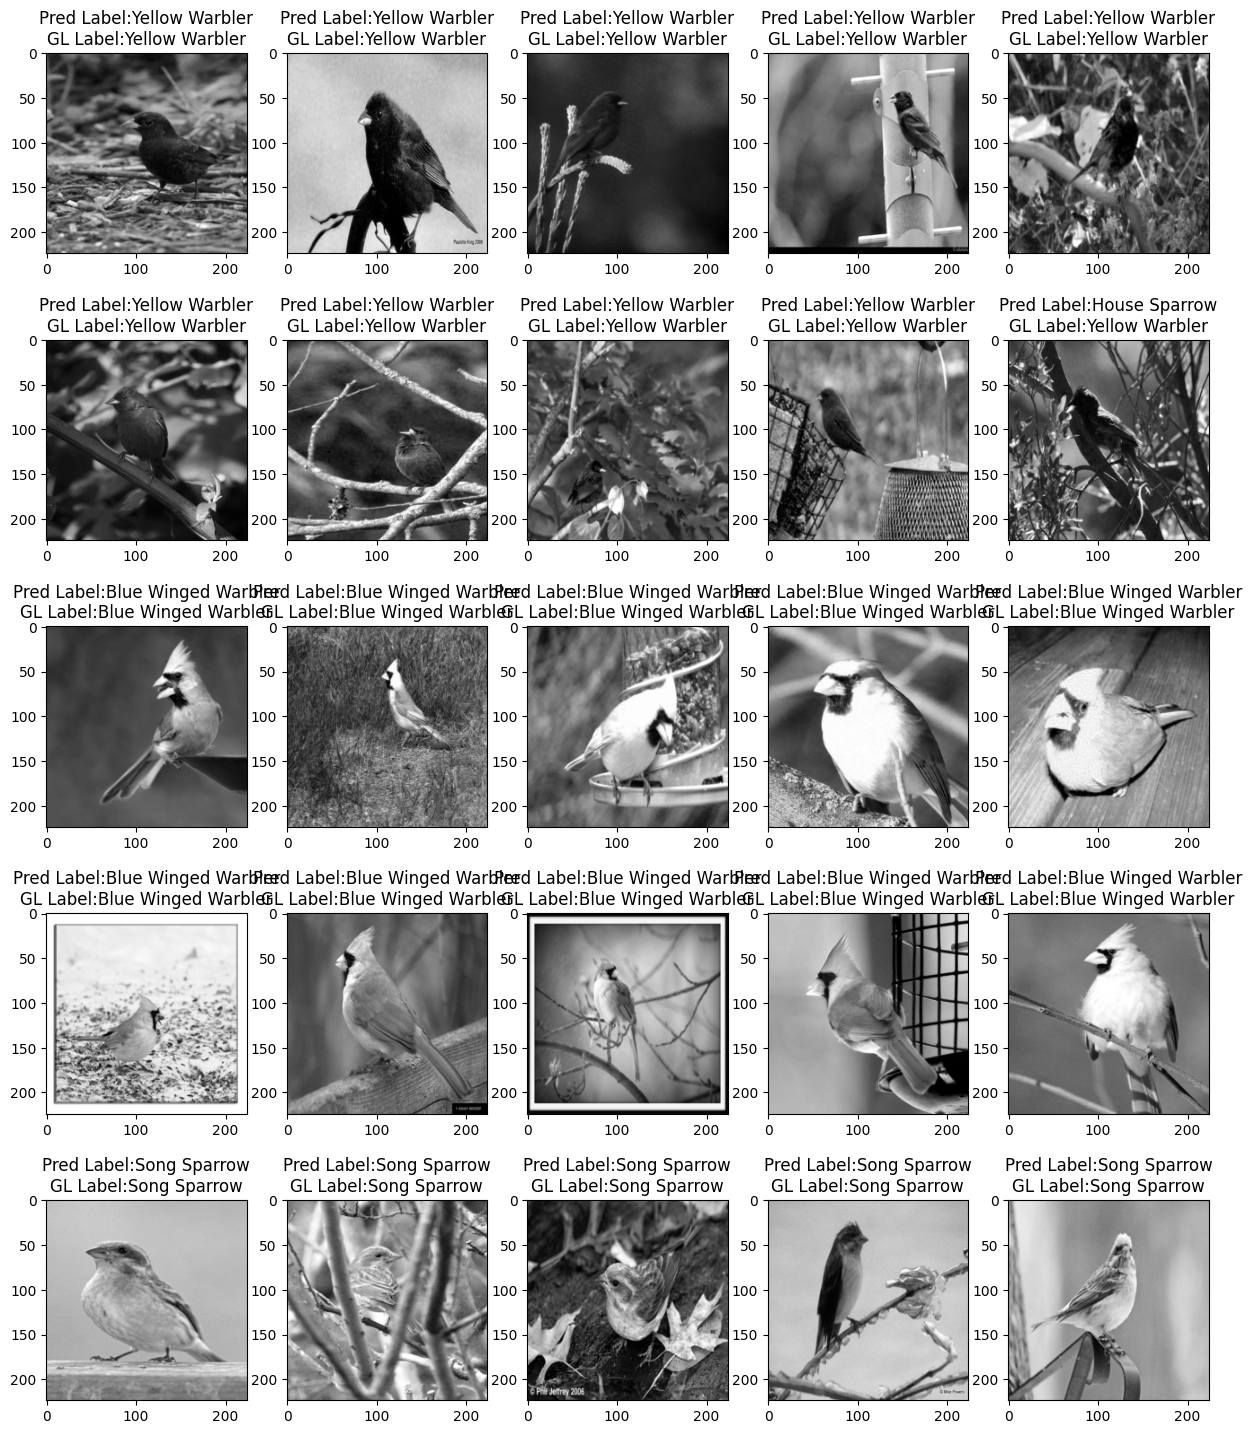

In [176]:

model.eval()
model = model.to("cuda")

for X, y in test_dataloader:
  X = X.to(device)
  y = y.to(device)
  with torch.no_grad():
    pred = model(X)
    pred_labels = pred.argmax(1)
  break

plt.figure(figsize=(15,18))
for i in range(25):
  y_hat = pred_labels[i].item()
  y_gt = y[i].item()
  plt.subplot(5,5,i+1)
  plt.imshow(X[i, 0, :, :].cpu().numpy(), cmap="gray")
  plt.title('Pred Label:%s\nGL Label:%s' %(classes[y_hat], classes[y_gt]))